In [41]:
import semopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from graphviz import Digraph
from IPython.display import display, Image

In [13]:
# =============================================================================
# Step 1: Load the Data and Preprocess
# =============================================================================
data = pd.read_csv('Fintech India-customer predispositions-CEB-advocacy.csv')
data.columns = data.columns.str.strip()  # Remove any spaces in column names


In [15]:
# =============================================================================
# Step 2: Define the SEM Model Specification
# =============================================================================
model_spec = """
# Measurement Model
CF =~ CF1 + CF2 + CF3
CA =~ CA1 + CA2 + CA3 + CA4
CEB =~ CEB_1+CEB_2+CEB_3 +CEB_4+CEB_5+CEB_6 +CEB_7+CEB_8 + CEB_9 + CEB_10 + CEB_11 + CEB_12+CEB_13 + CEB_14 + CEB_15+CEB_16+CEB_17+ CEB_18 + CEB_19
Emotion =~ Happiness + Pleasure + Contentment + Frustration
MI =~ MI1 + MI2 + MI3 + MI4 
PB =~ PB1 + PB2 + PB3 + PB4 + PB5 + PB6  
PC=~ PC1 + PC2 + PC3
SC =~ SC1 + SC2 + SC3 + SC4 + SC5

# Covariance between highly correlated latent variables
PB ~~ PC

# Regressions
CA ~ CEB       # H1: CEB → Customer Advocacy
CEB ~ Emotion  # H2: Emotion → CEB 
CA ~ Emotion   # H3  Emotion → CA
CEB ~ SC       # H4  SC→ CEBbefore
CA ~ SC        # H5  SC→ CA
CEB ~ MI       # H6  MI→ CEB
CA ~ MI        # H7  MI → CA
CEB ~ CF       # H8  CF → CEB
CA ~ CF        # H9  CF → CA
CEB ~ PC       # H10 PC → CEB
CEB ~ PB       # H11 PB→ CEB

"""


In [49]:
# =============================================================================
# Step 3: Fit the Model with Error Handling
# =============================================================================
model = semopy.Model(model_spec)
fitted = True

try:
    model.fit(data)
except np.linalg.LinAlgError as e:
    fitted = False
    print("\n❌ Singular matrix error: This may be due to multicollinearity or insufficient variation.")
except Exception as e:
    fitted = False
    print(f"\n❌ Error fitting the model: {e}")

In [81]:
from joblib import Parallel, delayed

def bootstrap_iteration(i, model_spec, data):
    """Perform one bootstrap iteration."""
    sample_data = data.sample(n=len(data), replace=True)
    boot_model = semopy.Model(model_spec)
    try:
        boot_model.fit(sample_data)
        params = boot_model.inspect()
        params['bootstrap_iter'] = i
        return params
    except Exception as e:
        print(f"Iteration {i} failed: {e}")
        return None

def manual_bootstrap_parallel(model_spec, data, n_bootstraps=200, n_jobs=-1):
    """
    Manually bootstrap the SEM model using parallel processing.
    
    Parameters:
        model_spec (str): The model specification string.
        data (pd.DataFrame): The observed data.
        n_bootstraps (int): Number of bootstrap iterations (default reduced to 100).
        n_jobs (int): Number of parallel jobs (-1 uses all available cores).
        
    Returns:
        boot_df (pd.DataFrame): Combined DataFrame of parameter estimates from each bootstrap iteration.
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(bootstrap_iteration)(i, model_spec, data) for i in range(n_bootstraps)
    )
    # Filter out any failed iterations
    results = [r for r in results if r is not None]
    if results:
        boot_df = pd.concat(results, ignore_index=True)
        return boot_df
    else:
        return None

# =============================================================================
# Example Integration into Your Workflow with Parallel Bootstrapping
# =============================================================================

if fitted:
    print("\n✅ Starting parallel manual bootstrapping of the SEM model (this may take a while)...")
    # Here we reduce n_bootstraps to 100 for speed; adjust as needed.
    boot_results = manual_bootstrap_parallel(model_spec, data, n_bootstraps=2000, n_jobs=-1)
    
    if boot_results is not None:
        print("\nBootstrapping Results (first 10 rows):")
        display(boot_results.head(10))
        # Compute summary statistics for each parameter:
        summary = boot_results.groupby(['lhs', 'op', 'rhs']).agg({'Est': ['mean', 'std', 'min', 'max']})
        print("\nBootstrapped Parameter Summary:")
        display(summary)
    else:
        print("\n❌ Bootstrapping did not produce any results.")
    
    # Now display the original parameter estimates
    params = model.inspect()
    print("\n✅ Original Model Parameter Estimates:")
    display(params)
else:
    print("\n❌ Model was not successfully fitted.")



✅ Starting parallel manual bootstrapping of the SEM model (this may take a while)...

Bootstrapping Results (first 10 rows):


,lval,op,rval,Estimate,Std. Err,z-value,p-value,bootstrap_iter
0,CA,~,CEB,0.201235,0.062294,3.230404,0.001236,0
1,CA,~,Emotion,0.185150,0.035003,5.289483,0.0,0
2,CA,~,SC,0.253283,0.062279,4.066895,0.000048,0
3,CA,~,MI,0.002513,0.07478,0.033609,0.973189,0
4,CA,~,CF,0.340566,0.058,5.871836,0.0,0
5,CEB,~,Emotion,0.063179,0.036188,1.74585,0.080837,0
6,CEB,~,SC,0.299967,0.068625,4.37113,0.000012,0
7,CEB,~,MI,-0.174100,0.079337,-2.194425,0.028205,0
8,CEB,~,CF,0.230959,0.062274,3.708749,0.000208,0
9,CEB,~,PC,0.307010,0.282271,1.087644,0.276752,0


KeyError: 'lhs'

In [87]:
# =============================================================================
# Step 4: Display Model Parameter Estimates
# =============================================================================
if fitted:
    params = model.inspect()
    print("\n✅ Model Parameter Estimates:")
    display(params)

else:
    print("\n❌ Model was not successfully fitted.")


✅ Model Parameter Estimates:


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,CA,~,CEB,0.281188,0.063547,4.42486,0.00001
1,CA,~,Emotion,0.195039,0.035063,5.562501,0.0
2,CA,~,SC,0.108867,0.072724,1.496991,0.134396
3,CA,~,MI,-0.001350,0.068002,-0.019849,0.984164
4,CA,~,CF,0.384307,0.066134,5.811063,0.0
...,...,...,...,...,...,...,...
125,SC1,~~,SC1,0.388102,0.033404,11.618357,0.0
126,SC2,~~,SC2,0.350242,0.032589,10.747325,0.0
127,SC3,~~,SC3,0.423016,0.036044,11.73625,0.0
128,SC4,~~,SC4,0.475968,0.042374,11.232639,0.0


In [89]:
# =============================================================================
# Step 4.1: Display Model Parameter Estimates
# =============================================================================

# Ensure model is fitted before displaying results
if fitted:
    # Display all 130 rows of model parameter estimates (full output)
   #  print("\n✅ Full Model Parameter Estimates (130 rows):")     FULL MODEL PARAMETER 
    # Uncomment the line below to display all 130 rows if needed
    # display(params)  

    # Extract and display only the 11 regressions
    regression_params = params[params['op'] == '~']
    print("\n✅ Model Parameter Estimates for the Regressions:")
    display(regression_params)
else:
    print("\n❌ Model Parameter Estimates: Not computed due to model fitting error.")



✅ Model Parameter Estimates for the Regressions:


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,CA,~,CEB,0.281188,0.063547,4.42486,0.00001
1,CA,~,Emotion,0.195039,0.035063,5.562501,0.0
2,CA,~,SC,0.108867,0.072724,1.496991,0.134396
3,CA,~,MI,-0.001350,0.068002,-0.019849,0.984164
4,CA,~,CF,0.384307,0.066134,5.811063,0.0
5,CEB,~,Emotion,0.047585,0.038049,1.250626,0.211071
6,CEB,~,SC,0.353093,0.078073,4.522593,0.000006
7,CEB,~,MI,-0.098152,0.074689,-1.314141,0.188799
8,CEB,~,CF,0.217917,0.068674,3.173199,0.001508
9,CEB,~,PC,0.198980,0.223676,0.889591,0.373685


In [71]:
# =============================================================================
# Step 5: Compute and Display Model Fit Indices
# =============================================================================
if fitted:
    fit_stats = semopy.calc_stats(model)
    print("\n✅ Model Fit Indices:")
    display(fit_stats)

else:
    print("\n❌ Model Fit Indices: Not computed due to model fitting error.")


✅ Model Fit Indices:


,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,1054,1128,3743.357432,0.0,13784.49792,0.787512,0.728437,0.709371,0.728437,0.772593,0.082051,224.298119,704.999012,9.850941


Extracted latent variables: ['CF', 'CA', 'CEB', 'Emotion', 'MI', 'PB', 'PC', 'SC']


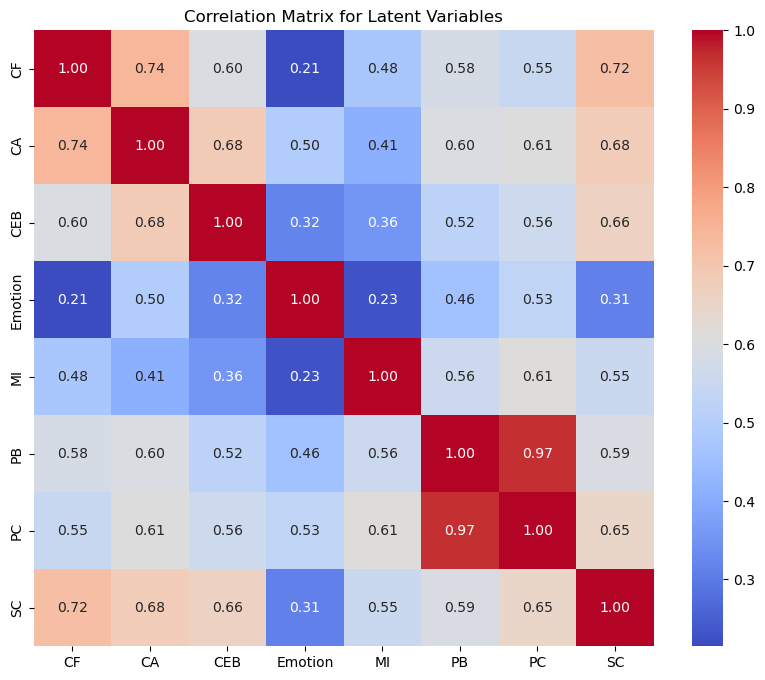


Variance Inflation Factor (VIF) for latent variables:


,Variable,VIF
1,CF,3.609292
2,CA,3.605448
3,CEB,2.310866
4,Emotion,1.851490
5,MI,1.873275
6,PB,21.322935
7,PC,26.584985
8,SC,3.430244


In [73]:
import re
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =============================================================================
# Step 6 (Improved): Analyze Latent Variables from the Measurement Model
# =============================================================================

# Automatically extract latent variable names from the measurement model in the specification
# This regex finds the left-hand side of each "=~" line.
latent_vars = re.findall(r"(\w+)\s*=~", model_spec)
print("Extracted latent variables:", latent_vars)

# Note: Emotion is always included, so no latent variable is excluded.

# Compute latent factor scores using semopy's predict_factors method
# (Assuming your fitted model can generate factor scores for all measurement model latent variables.)
latent_scores = model.predict_factors(data)

# Subset the factor scores to include only the extracted latent variables
latent_scores_subset = latent_scores[latent_vars]

# -------------------------------
# 6A: Plot the Correlation Matrix
# -------------------------------
plt.figure(figsize=(10, 8))
corr_latent = latent_scores_subset.corr()
sns.heatmap(corr_latent, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Latent Variables")
plt.show()

# -------------------------------
# 6B: Compute the Variance Inflation Factor (VIF)
# -------------------------------
# VIF is computed by regressing each latent variable on all the others.
# We add a constant (intercept) to the data for this purpose.
X = sm.add_constant(latent_scores_subset)
vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Remove the constant from the results, as it's not of interest
vif_data = vif_data[vif_data['Variable'] != 'const']
print("\nVariance Inflation Factor (VIF) for latent variables:")
display(vif_data)


In [57]:
# =============================================================================
# Step 6: Display Highly Correlated Variables
# =============================================================================
corr_matrix = data.corr()
threshold = 0.90
high_corr_pairs = []

# Identify highly correlated variable pairs
abs_corr = corr_matrix.abs()
columns = abs_corr.columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        if abs_corr.iloc[i, j] > threshold:
            high_corr_pairs.append((columns[i], columns[j], abs_corr.iloc[i, j]))

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Variable 1", "Variable 2", "Correlation"])
    tools.display_dataframe_to_user(name="Highly Correlated Variables", dataframe=high_corr_df)
else:
    print("\n✅ No highly correlated variable pairs found (|correlation| > 0.90).")



✅ No highly correlated variable pairs found (|correlation| > 0.90).



Generating Clean Path Diagram:


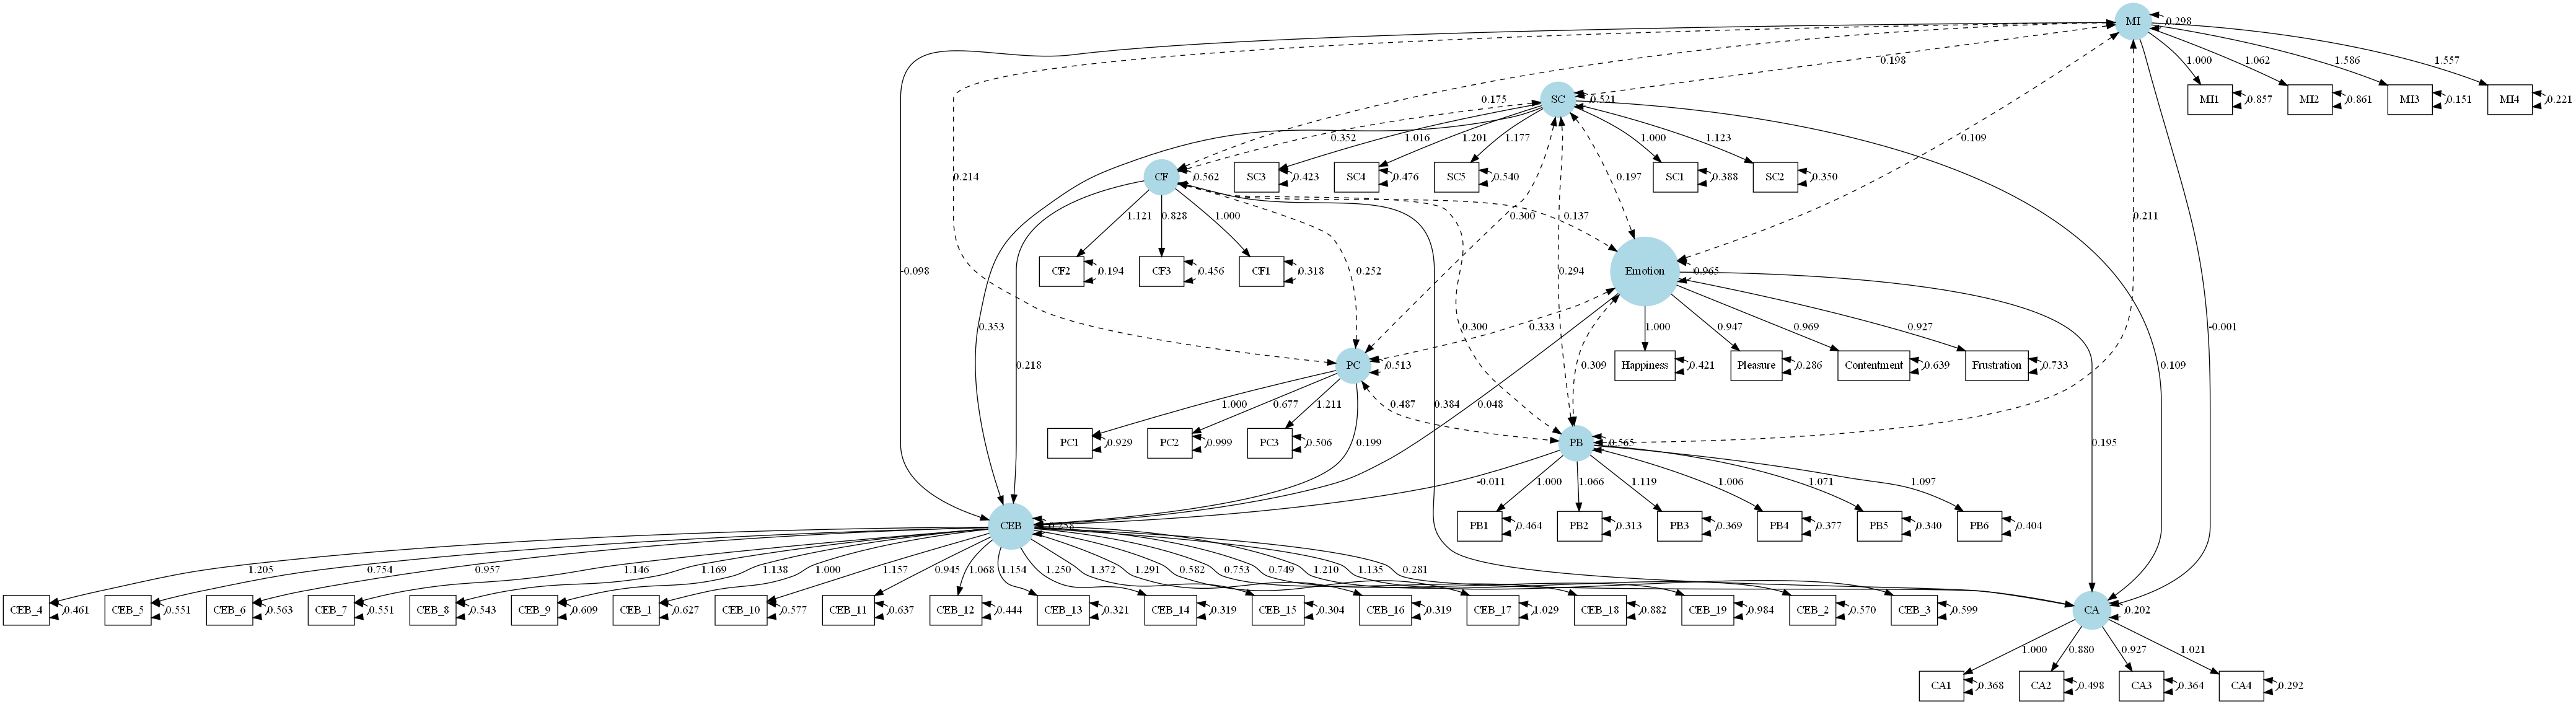

✅ Clean path diagram displayed inline.



In [21]:
# =============================================================================
# Step 8: Generate and Display Path Diagram
# =============================================================================
def display_clean_path_diagram(model, params=None, format='png'):
    dot = Digraph(format=format)

    # Add latent variables as circles
    for latent in model.vars['latent']:
        dot.node(latent, latent, shape='circle', style='filled', color='lightblue')

    # Add observed variables as rectangles
    for observed in model.vars['observed']:
        dot.node(observed, observed, shape='rectangle')

    # Add paths based on parameter estimates (if available)
    if params is not None:
        for _, row in params.iterrows():
            op = row['op']
            if op == '=~':  # Measurement (factor loadings)
                dot.edge(row['lval'], row['rval'], label=f"{row['Estimate']:.3f}")
            elif op == '~':  # Regression paths
                dot.edge(row['rval'], row['lval'], label=f"{row['Estimate']:.3f}")
            elif op == '~~':  # Covariances
                dot.edge(row['lval'], row['rval'], dir='both', style='dashed', label=f"{row['Estimate']:.3f}")

    try:
        # Get image data from Graphviz and display inline
        png_data = dot.pipe(format=format)
        display(Image(data=png_data))
        print("✅ Clean path diagram displayed inline.\n")
    except Exception as e:
        print("❌ Error displaying the clean path diagram:", e)

if fitted:
    print("\nGenerating Clean Path Diagram:")
    display_clean_path_diagram(model, params)
else:
    print("\n❌ Path Diagram: Not generated due to model fitting error.")


In [91]:
# =============================================================================
# Step 7: Compute and Display Predicted Latent Factors
# =============================================================================

if fitted:
    try:
        predicted_factors = model.predict_factors(data)
        print("\n✅ Predicted Latent Factors (First 10 Rows):")
        display(predicted_factors.head(10))  # Show only the first 10 rows for readability
    except np.linalg.LinAlgError as e:
        print("\n❌ A linear algebra error occurred while predicting latent factors (Singular matrix).")
        print("Possible reasons include:")
        print("  1. Multicollinearity among observed variables.")
        print("  2. Insufficient variation in some indicators.")
        print("  3. Over-parameterization of the SEM model.")
        print("  4. Data issues such as missing values or extreme outliers.")
        print("Error details:", e)
else:
    print("\n❌ Predicted Latent Factors: Not computed due to model fitting error.")


✅ Predicted Latent Factors (First 10 Rows):


,CA,CEB,CF,Emotion,MI,PB,PC,SC
0,0.675532,0.697354,0.675044,0.065229,0.355864,0.231537,0.246698,0.465481
1,0.521122,0.203593,0.446032,-0.367799,0.094196,0.262515,0.287033,0.422412
2,0.153919,-0.721920,-0.181831,1.035574,0.094885,0.398154,0.564424,0.190843
3,-1.143223,-0.724793,-0.263593,-0.358435,0.071745,0.100203,-0.088834,-0.990890
4,-0.198282,-0.027214,0.561332,-1.342323,0.118754,-0.018996,0.002251,0.217042
5,0.068501,0.117196,0.589945,-0.907675,0.125607,-0.057144,-0.342328,-0.016759
6,0.740680,0.712597,0.570483,1.041671,0.277412,0.544313,0.649182,0.875089
7,0.605528,0.726454,-0.007514,0.704224,0.025982,0.359851,0.385283,-0.315650
8,0.442129,-0.515616,1.372136,-0.716850,0.254685,0.384683,0.267078,0.695528
9,0.362978,0.178340,0.350905,0.013684,0.714300,0.519768,0.298653,0.097381


In [93]:
from scipy.stats import norm
import numpy as np
from tabulate import tabulate

def test_mediation_no_bootstrap_prompt(params):
    """
    Tests the mediation effect (X → M → Y) WITHOUT bootstrapping, prompting user for X, M, Y.

    Computes:
    - Direct effects: X → M, M → Y
    - Indirect effect: X → M → Y (using Sobel's formula)
    - z-values and p-values for each path

    Parameters:
    - params: A DataFrame from model.inspect(std_est=True) in semopy
              (columns: lval, rval, Estimate, Std. Err, op).

    Example usage (assuming your model is already fitted):
        model.fit(data)
        params = model.inspect(std_est=True)
        test_mediation_no_bootstrap_prompt(params)
        # Then type e.g., X=C, M=B, Y=A when prompted
    """

    # Prompt the user for X, M, Y
    predictor = input("Enter the Predictor (X): ").strip()
    mediator  = input("Enter the Mediator  (M): ").strip()
    outcome   = input("Enter the Outcome   (Y): ").strip()

    # Extract the relevant paths from the parameters
    path_X_M = params[(params['lval'] == mediator) & (params['rval'] == predictor) & (params['op'] == '~')]
    path_M_Y = params[(params['lval'] == outcome) & (params['rval'] == mediator) & (params['op'] == '~')]

    # Check if required paths exist
    if path_X_M.empty or path_M_Y.empty:
        missing_paths = []
        if path_X_M.empty:
            missing_paths.append(f"{predictor} → {mediator}")
        if path_M_Y.empty:
            missing_paths.append(f"{mediator} → {outcome}")
        raise ValueError(f"❌ Missing paths: {', '.join(missing_paths)}\n"
                         f"Make sure your model specification matches these directions.")

    # Extract estimates and standard errors
    estimate_X_M = path_X_M['Estimate'].values[0]
    std_err_X_M  = path_X_M['Std. Err'].values[0]

    estimate_M_Y = path_M_Y['Estimate'].values[0]
    std_err_M_Y  = path_M_Y['Std. Err'].values[0]

    # Compute direct path z-values & p-values
    z_value_X_M  = estimate_X_M / std_err_X_M
    p_value_X_M  = 2 * (1 - norm.cdf(abs(z_value_X_M)))

    z_value_M_Y  = estimate_M_Y / std_err_M_Y
    p_value_M_Y  = 2 * (1 - norm.cdf(abs(z_value_M_Y)))

    # Compute indirect effect
    indirect_effect = estimate_X_M * estimate_M_Y

    # Sobel's formula for indirect std. err
    indirect_std_err = np.sqrt(
        (estimate_M_Y ** 2) * (std_err_X_M ** 2) +
        (estimate_X_M ** 2) * (std_err_M_Y ** 2)
    )

    # z-value & p-value for indirect effect
    z_value_indirect = indirect_effect / indirect_std_err
    p_value_indirect = 2 * (1 - norm.cdf(abs(z_value_indirect)))

    # Display the results in a table
    print(f"\n✅ Mediation Analysis (No Bootstrap): {predictor} → {mediator} → {outcome}")
    table = [
        [f"{predictor} → {mediator}", estimate_X_M, std_err_X_M, z_value_X_M, p_value_X_M],
        [f"{mediator} → {outcome}", estimate_M_Y, std_err_M_Y, z_value_M_Y, p_value_M_Y],
        [f"Indirect ({predictor} → {mediator} → {outcome})", indirect_effect, indirect_std_err, z_value_indirect, p_value_indirect]
    ]
    headers = ["Path", "Estimate", "Std. Err", "z-value", "p-value"]
    print(tabulate(table, headers=headers, tablefmt="pretty"))

    # Return results as a dictionary
    return {
        "paths": {
            f"{predictor} → {mediator}": {
                "estimate": estimate_X_M,
                "std_err": std_err_X_M,
                "z_value": z_value_X_M,
                "p_value": p_value_X_M
            },
            f"{mediator} → {outcome}": {
                "estimate": estimate_M_Y,
                "std_err": std_err_M_Y,
                "z_value": z_value_M_Y,
                "p_value": p_value_M_Y
            },
            f"Indirect ({predictor} → {mediator} → {outcome})": {
                "estimate": indirect_effect,
                "std_err": indirect_std_err,
                "z_value": z_value_indirect,
                "p_value": p_value_indirect
            }
        }
    }

# Example usage:
# 1. Fit your semopy model:
model.fit(data)
# 2. Inspect parameters:
params = model.inspect(std_est=True)
# 3. Run the mediation function, then type e.g. X=C, M=B, Y=A
test_mediation_no_bootstrap_prompt(params)#call


Enter the Predictor (X):  CF
Enter the Mediator  (M):  CEB
Enter the Outcome   (Y):  CA



✅ Mediation Analysis (No Bootstrap): CF → CEB → CA
+--------------------------+----------------------+----------------------+--------------------+-----------------------+
|           Path           |       Estimate       |       Std. Err       |      z-value       |        p-value        |
+--------------------------+----------------------+----------------------+--------------------+-----------------------+
|         CF → CEB         |  0.2179169149758377  | 0.06867421458996222  | 3.173198503644621  | 0.0015076940305975839 |
|         CEB → CA         | 0.28118756854015786  | 0.06354722887857626  | 4.424859643800374  |  9.6505006359493e-06  |
| Indirect (CF → CEB → CA) | 0.061275527465828115 | 0.023762504145232892 | 2.5786645671399446 | 0.009918304424610502  |
+--------------------------+----------------------+----------------------+--------------------+-----------------------+


{'paths': {'CF → CEB': {'estimate': 0.2179169149758377,
   'std_err': 0.06867421458996222,
   'z_value': 3.173198503644621,
   'p_value': 0.0015076940305975839},
  'CEB → CA': {'estimate': 0.28118756854015786,
   'std_err': 0.06354722887857626,
   'z_value': 4.424859643800374,
   'p_value': 9.6505006359493e-06},
  'Indirect (CF → CEB → CA)': {'estimate': 0.061275527465828115,
   'std_err': 0.023762504145232892,
   'z_value': 2.5786645671399446,
   'p_value': 0.009918304424610502}}}

In [27]:
test_mediation_no_bootstrap_prompt(params)#call


Enter the Predictor (X):  CF
Enter the Mediator  (M):  CEB
Enter the Outcome   (Y):  CA



✅ Mediation Analysis (No Bootstrap): CF → CEB → CA
+--------------------------+---------------------+---------------------+--------------------+-----------------------+
|           Path           |      Estimate       |      Std. Err       |      z-value       |        p-value        |
+--------------------------+---------------------+---------------------+--------------------+-----------------------+
|         CF → CEB         | 0.21791691497577098 | 0.06867421459009304 | 3.1731985036376043 | 0.0015076940306339992 |
|         CEB → CA         | 0.2811875685398261  | 0.06354722887861042 | 4.424859643792776  | 9.650500636393389e-06 |
| Indirect (CF → CEB → CA) | 0.06127552746573706 | 0.02376250414524614 | 2.5786645671346755 | 0.009918304424761715  |
+--------------------------+---------------------+---------------------+--------------------+-----------------------+


{'paths': {'CF → CEB': {'estimate': 0.21791691497577098,
   'std_err': 0.06867421459009304,
   'z_value': 3.1731985036376043,
   'p_value': 0.0015076940306339992},
  'CEB → CA': {'estimate': 0.2811875685398261,
   'std_err': 0.06354722887861042,
   'z_value': 4.424859643792776,
   'p_value': 9.650500636393389e-06},
  'Indirect (CF → CEB → CA)': {'estimate': 0.06127552746573706,
   'std_err': 0.02376250414524614,
   'z_value': 2.5786645671346755,
   'p_value': 0.009918304424761715}}}

In [29]:
test_mediation_no_bootstrap_prompt(params)#call


Enter the Predictor (X):  PB
Enter the Mediator  (M):  CEB
Enter the Outcome   (Y):  CA



✅ Mediation Analysis (No Bootstrap): PB → CEB → CA
+--------------------------+-----------------------+---------------------+-----------------------+-----------------------+
|           Path           |       Estimate        |      Std. Err       |        z-value        |        p-value        |
+--------------------------+-----------------------+---------------------+-----------------------+-----------------------+
|         PB → CEB         |  -0.0114954850640857  | 0.18466750535052523 | -0.06224963640606739  |  0.9503640349675542   |
|         CEB → CA         |  0.2811875685398261   | 0.06354722887861042 |   4.424859643792776   | 9.650500636393389e-06 |
| Indirect (PB → CEB → CA) | -0.003232387494356145 | 0.05193134500305286 | -0.062243477309631104 |  0.9503689397042696   |
+--------------------------+-----------------------+---------------------+-----------------------+-----------------------+


{'paths': {'PB → CEB': {'estimate': -0.0114954850640857,
   'std_err': 0.18466750535052523,
   'z_value': -0.06224963640606739,
   'p_value': 0.9503640349675542},
  'CEB → CA': {'estimate': 0.2811875685398261,
   'std_err': 0.06354722887861042,
   'z_value': 4.424859643792776,
   'p_value': 9.650500636393389e-06},
  'Indirect (PB → CEB → CA)': {'estimate': -0.003232387494356145,
   'std_err': 0.05193134500305286,
   'z_value': -0.062243477309631104,
   'p_value': 0.9503689397042696}}}